## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
rcParams['figure.dpi'] = 120
rcParams['figure.facecolor'] = 'w'
import hapclust
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

cartopy 0.16.0


In [2]:
df_samples = phase1_ar3.df_samples
df_samples.columns

Index(['ox_code', 'src_code', 'sra_sample_accession', 'population', 'country',
       'region', 'contributor', 'contact', 'year', 'm_s', 'sex', 'n_sequences',
       'mean_coverage', 'latitude', 'longitude', 'kt_2la', 'kt_2rb',
       'kdr_1014', 'rdl_296', 'f_roh_100kb', 'count_roh_100kb',
       'sum_roh_100kb', 'pca_3R_free_pc1', 'pca_3R_free_pc2',
       'pca_3R_free_pc3', 'pca_3R_free_pc4', 'pca_3L_free_pc1',
       'pca_3L_free_pc2', 'pca_3L_free_pc3', 'pca_3L_free_pc4', 'pca_2La_pc1',
       'pca_2La_pc2', 'pca_2La_pc3', 'pca_2La_pc4', 'pca_2Rb_pc1',
       'pca_2Rb_pc2', 'pca_2Rb_pc3', 'pca_2Rb_pc4'],
      dtype='object')

In [3]:
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [4]:
# use the network membership to define haplotype groups
vgsc_clusters = np.load('../data/median_joining_network_membership.npy').astype('U')
clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) 
              for l in np.unique(vgsc_clusters)}


In [5]:
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'FX', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4', 'S5', 'SX'])

In [6]:
# merge the "other resistant" groups
clust_dict['other_resistant'] = clust_dict['FX'] | clust_dict['SX']
del clust_dict['FX']
del clust_dict['SX']

In [7]:
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4', 'S5', 'other_resistant'])

In [8]:
#using different clusterings/files

# with open('../data/clust_dict.pickle', 'rb') as handle:
#     clust_dict = peterpickedapickledpepper.load(handle)


# vgsc_clusters = np.load('../data/vgsc_cluster_membership.npy').astype('U')
# clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) for l in np.unique(vgsc_clusters)}


# with open('../data/core_haps.pkl', mode='rb') as f:
#     clust_dict = pickle.load(f)
# core_haps_simple = dict()
# fx = set()
# sx = set()
# lx = set()
# wt = set()
# for k, v in clust_dict.items():
#     if k.startswith('FX'):
#         fx |= v
#     elif k.startswith('SX'):
#         sx |= v
#     elif k.startswith('LX'):
#         lx |= v
#     elif k.startswith('WT'):
#         wt |= v
#     else:
#         core_haps_simple[k] = v
# core_haps_simple['FX'] = fx
# core_haps_simple['SX'] = sx
# core_haps_simple['LX'] = lx
# core_haps_simple['WT'] = wt
# clust_dict = core_haps_simple

In [9]:
hap_labels = sorted(clust_dict)
# reorder for aesthetics
hap_labels = (
    [l for l in hap_labels if l.startswith('F')] +
    [l for l in hap_labels if l.startswith('S')] +
    [l for l in hap_labels if l.startswith('L')] +
    ['other_resistant', 'wt']
)
hap_labels

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'L1',
 'L2',
 'other_resistant',
 'wt']

In [10]:
def make_df_pops():
    global df_pops

    tbl_pops = (
        etl
        .wrap([
            ['pop', 'long_label', 'short_label', 'query'],
            ['AOM', 'Angola $coluzzii$', 'AO$Ac$', 'population == "AOM"'],
            ['BFM', 'Burkina Faso $coluzzii$', 'BF$Ac$', 'population == "BFM"'],
            ['BFS', 'Burkina Faso $gambiae$', 'BF$Ag$', 'population == "BFS"'],
            ['GNS', 'Guinea $gambiae$', 'GN$Ag$', 'population == "GNS"'],
            ['CMS', 'Cameroon $gambiae$', 'CM$Ag$', 'population == "CMS"'],
            ['CMS_savanna', 'Cameroon (savanna) $gambiae$', 'CM$Ag$', 'population == "CMS" and (region == "Gado-Badzere" or region == "Zembe-Borongo")'],
            ['CMS_transition', 'Cameroon (transition) $gambiae$', '', 'population == "CMS" and region == "Daiguene"'],
            ['CMS_forest', 'Cameroon (forest) $gambiae$', '', 'population == "CMS" and region == "Mayos"'],
            ['GAS', 'Gabon $gambiae$', 'GA$Ag$', 'population == "GAS"'],
            ['UGS', 'Uganda $gambiae$', 'UG$Ag$', 'population == "UGS"'],
            ['KES', 'Kenya', 'KE', 'population == "KES"'],
            ['GWA', 'Guinea-Bissau', 'GW', 'population == "GWA"'],
        ])
        .addfield('latitude', lambda row: df_samples.query(row.query).latitude.mean())
        .addfield('longitude', lambda row: df_samples.query(row.query).longitude.mean())
        .addfield('n_haps', lambda row: len(df_haplotypes.query(row.query)))
    )

    df_pops = tbl_pops.todataframe()
    df_pops = df_pops.set_index('pop')
    
    
make_df_pops()
df_pops

,long_label,short_label,query,latitude,longitude,n_haps
pop,,,,,,
AOM,Angola $coluzzii$,AO$Ac$,"population == ""AOM""",-8.821000,13.291000,120
BFM,Burkina Faso $coluzzii$,BF$Ac$,"population == ""BFM""",11.221609,-4.457739,138
BFS,Burkina Faso $gambiae$,BF$Ag$,"population == ""BFS""",11.193630,-4.376556,162
GNS,Guinea $gambiae$,GN$Ag$,"population == ""GNS""",8.887097,-9.675065,62
CMS,Cameroon $gambiae$,CM$Ag$,"population == ""CMS""",4.937851,13.936844,550
CMS_savanna,Cameroon (savanna) $gambiae$,CM$Ag$,"population == ""CMS"" and (region == ""Gado-Badze...",5.747000,14.442000,182
CMS_transition,Cameroon (transition) $gambiae$,,"population == ""CMS"" and region == ""Daiguene""",4.777000,13.844000,166
CMS_forest,Cameroon (forest) $gambiae$,,"population == ""CMS"" and region == ""Mayos""",4.341000,13.558000,202
GAS,Gabon $gambiae$,GA$Ag$,"population == ""GAS""",0.384000,9.455000,112


In [11]:
crs_lonlat = ccrs.PlateCarree()
ratios = np.asarray([0.5, 0.5])
sum(ratios)

1.0

## Calculate haplotype frequencies across populations

In [12]:
def compute_hap_freqs():
    global df_freqs
    
    n_pops = len(df_pops)
    n_haps = len(hap_labels)
    hap_frequencies = np.zeros([n_pops, n_haps], dtype=int)

    # then loop through clusters
    for i, pop in enumerate(df_pops.index):
        pop_query = df_pops.loc[pop].query
        pop_hap_ixs = set(df_haplotypes.query(pop_query).index.values)
        for j, label in enumerate(hap_labels):
            core_hap_ixs = clust_dict[label]
            isec = pop_hap_ixs.intersection(core_hap_ixs)
            hap_frequencies[i, j] = len(isec)


    counts = df_pops.n_haps
    counts

    # make df for plotting
    df_freqs = pd.DataFrame(data=hap_frequencies, index=df_pops.index, columns=hap_labels)
    df_freqs['other'] = counts - df_freqs.sum(axis=1).values
    df_freqs['total'] = counts
    
compute_hap_freqs()
df_freqs

,F1,F2,F3,F4,F5,S1,S2,S3,S4,S5,L1,L2,other_resistant,wt,other,total
pop,,,,,,,,,,,,,,,,
AOM,89,0,0,0,0,0,0,0,0,0,0,0,14,17,0,120
BFM,110,0,0,0,0,0,0,0,0,0,19,0,6,3,0,138
BFS,161,0,0,0,0,0,0,0,0,0,0,0,1,0,0,162
GNS,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62
CMS,34,13,50,19,163,0,8,0,36,34,0,0,19,174,0,550
CMS_savanna,3,2,26,9,47,0,1,0,12,10,0,0,9,63,0,182
CMS_transition,15,6,17,4,53,0,4,0,10,10,0,0,5,42,0,166
CMS_forest,16,5,7,6,63,0,3,0,14,14,0,0,5,69,0,202
GAS,0,0,0,16,24,0,70,0,0,0,0,0,2,0,0,112


In [13]:
# test CMS breakdown is significant
def test_cms_breakdown():
    arr = np.asarray(df_freqs
                     .loc[['CMS_savanna', 'CMS_transition', 'CMS_forest']]
                     .iloc[:, :len(hap_labels) + 1])
    # remove zeros
    arr = arr.compress(arr.sum(axis=0) > 0, axis=1)
    return scipy.stats.chi2_contingency(arr)

test_cms_breakdown()

(34.786446399424776,
 0.010054592130370302,
 18,
 array([[ 11.25090909,   4.30181818,  16.54545455,   6.28727273,
          53.93818182,   2.64727273,  11.91272727,  11.25090909,
           6.28727273,  57.57818182],
        [ 10.26181818,   3.92363636,  15.09090909,   5.73454545,
          49.19636364,   2.41454545,  10.86545455,  10.26181818,
           5.73454545,  52.51636364],
        [ 12.48727273,   4.77454545,  18.36363636,   6.97818182,
          59.86545455,   2.93818182,  13.22181818,  12.48727273,
           6.97818182,  63.90545455]]))

## build matplotlib pies - use colours from original dendrogram

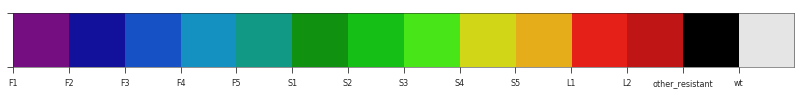

In [14]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

In [15]:
df_pops

,long_label,short_label,query,latitude,longitude,n_haps
pop,,,,,,
AOM,Angola $coluzzii$,AO$Ac$,"population == ""AOM""",-8.821000,13.291000,120
BFM,Burkina Faso $coluzzii$,BF$Ac$,"population == ""BFM""",11.221609,-4.457739,138
BFS,Burkina Faso $gambiae$,BF$Ag$,"population == ""BFS""",11.193630,-4.376556,162
GNS,Guinea $gambiae$,GN$Ag$,"population == ""GNS""",8.887097,-9.675065,62
CMS,Cameroon $gambiae$,CM$Ag$,"population == ""CMS""",4.937851,13.936844,550
CMS_savanna,Cameroon (savanna) $gambiae$,CM$Ag$,"population == ""CMS"" and (region == ""Gado-Badze...",5.747000,14.442000,182
CMS_transition,Cameroon (transition) $gambiae$,,"population == ""CMS"" and region == ""Daiguene""",4.777000,13.844000,166
CMS_forest,Cameroon (forest) $gambiae$,,"population == ""CMS"" and region == ""Mayos""",4.341000,13.558000,202
GAS,Gabon $gambiae$,GA$Ag$,"population == ""GAS""",0.384000,9.455000,112


In [16]:
def make_df_lonlat():
    global df_lonlat
    df_lonlat = df_pops[['latitude', 'longitude']].copy()
    df_lonlat['offset_latitude'] = np.zeros(len(df_lonlat))
    df_lonlat['offset_longitude'] = np.zeros(len(df_lonlat))
    df_lonlat.loc['BFS'].offset_latitude = 2
    df_lonlat.loc['BFS'].offset_longitude = 2
    df_lonlat.loc['BFM'].offset_latitude = 2
    df_lonlat.loc['BFM'].offset_longitude = -2
    df_lonlat.loc['CMS_savanna'].offset_latitude = 3.5
    df_lonlat.loc['CMS_savanna'].offset_longitude = 0.5
    df_lonlat.loc['CMS_transition'].offset_latitude = 0.5
    df_lonlat.loc['CMS_transition'].offset_longitude = 3
    df_lonlat.loc['CMS_forest'].offset_latitude = -3
    df_lonlat.loc['CMS_forest'].offset_longitude = 1
    df_lonlat.loc['GAS'].offset_latitude = .5
    df_lonlat.loc['GAS'].offset_longitude = -3

make_df_lonlat()
df_lonlat

,latitude,longitude,offset_latitude,offset_longitude
pop,,,,
AOM,-8.821000,13.291000,0.0,0.0
BFM,11.221609,-4.457739,2.0,-2.0
BFS,11.193630,-4.376556,2.0,2.0
GNS,8.887097,-9.675065,0.0,0.0
CMS,4.937851,13.936844,0.0,0.0
CMS_savanna,5.747000,14.442000,3.5,0.5
CMS_transition,4.777000,13.844000,0.5,3.0
CMS_forest,4.341000,13.558000,-3.0,1.0
GAS,0.384000,9.455000,0.5,-3.0


In [17]:
# for legend
hap_colors = {l: c for l, c in zip(hap_labels, palette)}
hap_colors

{'F1': (0.45607725490196099, 0.056599607843137223, 0.50939647058823534),
 'F2': (0.06784647058823523, 0.06784647058823523, 0.61061823529411763),
 'F3': (0.086670000000000025, 0.32093509803921522, 0.78003),
 'F4': (0.084317058823529356, 0.57059470588235295, 0.75885352941176476),
 'F5': (0.066670000000000007, 0.60002999999999995, 0.52679078431372561),
 'S1': (0.063397843137254828, 0.57058058823529412, 0.063397843137254828),
 'S2': (0.083269607843137194, 0.74942647058823542, 0.083269607843137194),
 'S3': (0.2840439215686274, 0.90000000000000002, 0.099999999999999978),
 'S4': (0.82193117647058844, 0.84703235294117651, 0.094114705882352934),
 'S5': (0.90000000000000002, 0.68039215686274546, 0.099999999999999978),
 'L1': (0.90000000000000002, 0.12823529411764703, 0.099999999999999978),
 'L2': (0.74942647058823542, 0.083269607843137194, 0.083269607843137194),
 'other_resistant': (0, 0, 0),
 'wt': (0.9, 0.9, 0.9)}

In [18]:
df_lonlat.loc[['BFS', 'BFM']]

,latitude,longitude,offset_latitude,offset_longitude
pop,,,,
BFS,11.193630,-4.376556,2.0,2.0
BFM,11.221609,-4.457739,2.0,-2.0


In [19]:
pops_cms_whole = [p for p in df_pops.index if p not in {'CMS_savanna', 'CMS_transition', 'CMS_forest'}]
pops_cms_whole

['AOM', 'BFM', 'BFS', 'GNS', 'CMS', 'GAS', 'UGS', 'KES', 'GWA']

In [20]:
pops_cms_breakdown = [p for p in df_pops.index if p != 'CMS']
pops_cms_breakdown

['AOM',
 'BFM',
 'BFS',
 'GNS',
 'CMS_savanna',
 'CMS_transition',
 'CMS_forest',
 'GAS',
 'UGS',
 'KES',
 'GWA']

In [21]:
human_hap_labels = {k: k for k in hap_labels}
human_hap_labels['other_resistant'] = 'other $kdr$'
human_hap_labels['wt'] = '$wt$'

In [22]:
def plot_map(pops, fn=None, dpi=150):

    #our frame
    extent_lonlat = (-20, 45, -13, 20)

    #plot
    subplot_kw = dict(projection=crs_lonlat)
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120, subplot_kw=subplot_kw)
    ax.coastlines(resolution='50m', linewidth=1, zorder=1)
    ax.stock_img()
    ax.add_feature(cfeature.BORDERS, lw=1, zorder=4)
    ax.add_feature(cfeature.LAKES)
    #ax.margins(0)

    #add pies
    for pop, row in df_lonlat.loc[pops].iterrows():
        freqs = df_freqs.loc[pop]
        ratios = np.asarray([freqs[k]/freqs['total'] for k in hap_labels])
        ratios = np.append(ratios, 1 - np.sum(ratios))
        # wedgeprops is used here just to pass the zorder command
        center = (row.longitude + row.offset_longitude, row.latitude + row.offset_latitude)
        radius = np.sqrt(df_freqs.loc[pop].total * .02)
        ax.pie(ratios, wedgeprops=dict(zorder=7), colors=palette, 
               center=center, radius=radius, shadow=True)
        ax.add_patch(plt.Circle(xy=center, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        if row.offset_latitude > 0 or row.offset_longitude > 0:
            ax.plot([row.longitude, row.longitude + row.offset_longitude],
                    [row.latitude, row.latitude + row.offset_latitude], 'k-', lw=2)
        lbl = df_pops.loc[pop].short_label
        ax.text(center[0], center[1] + radius, lbl, ha='center', va='bottom', fontsize=8, fontweight='bold', 
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)

    ax.set_extent(extent_lonlat, crs=crs_lonlat)

    handles = [mpl.patches.Patch(facecolor=hap_colors[k], edgecolor='k', label=human_hap_labels[k]) for k in hap_labels]
    leg = ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left', title='Haplotype\ngroup', )
    leg._legend_box.align = "left"
    
    #save
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
    

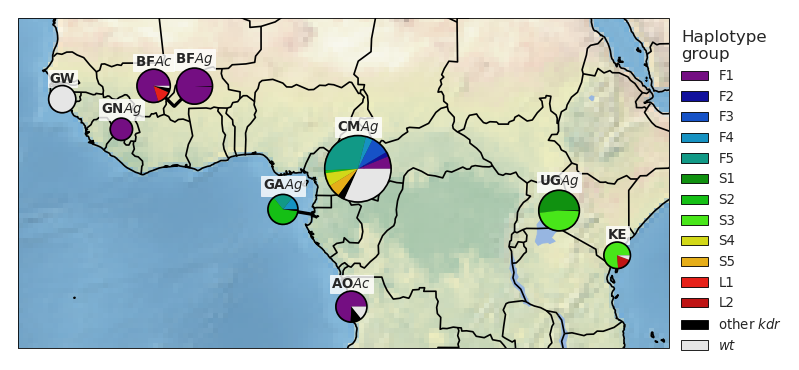

In [23]:
plot_map(pops=pops_cms_whole, fn='../artwork/outbreak_map_base.pdf')

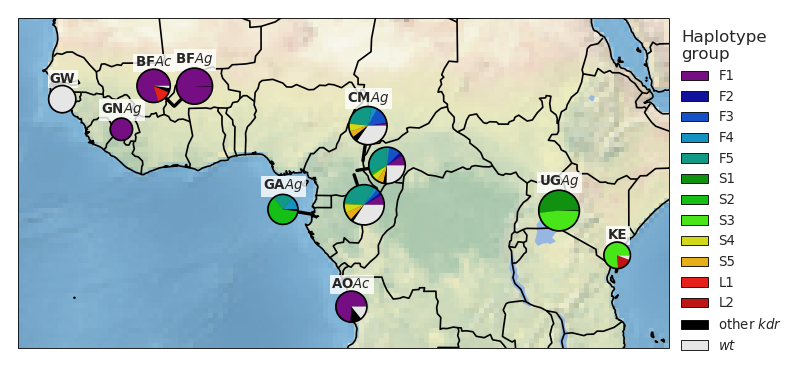

In [24]:
plot_map(pops=pops_cms_breakdown, fn='../artwork/outbreak_map_base_cms_breakdown.pdf')